In [1]:
import numpy as np
import json as js
import networkx as nx
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

In [2]:
file = open('export.json',)
data = js.load(file)
elements = data["elements"]
file.close()

In [3]:
def haversine(point1, point2):
    lat1, lon1, lat2, lon2 = map(radians, [point1[0], point1[1], point2[0], point2[1]])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of the Earth in kilometers. Use 3956 for miles. Determines return value units.
    return round(c * r,2)

In [4]:
#regroupe les coordonnées en couple
#nodesMap = {id, [lat, lon, stations, marqué]}
def createNodesMap(elements):
    nodesMap = {}
    for e in elements:
        if (e["type"] == "node"):
            if("tags" in e):
                if("name" in e["tags"]):
                    if(e["tags"]["name"].startswith("Aire")):
                        point = [e["lat"],e["lon"],1,0,e["tags"]["name"]]
                    else:
                        point = [e["lat"],e["lon"],0,0,None]
                else:
                    point = [e["lat"],e["lon"],0,0,None]

            else:
                point = [e["lat"],e["lon"],0,0,None]
            # ajout dans le dictionnaire
            nodesMap.update({e["id"] : point})

    return nodesMap

nodesMap = createNodesMap(elements)

In [5]:
def initialize_ways(elements, nodesMap):
    motorway_nodes = {}  # Dictionnaire pour les nœuds associés à motorway
    trunk_nodes = {}  # Dictionnaire pour les nœuds associés à trunk
    other_area_nodes = {}  # Dictionnaire pour les nœuds associés à d'autres types d'aires

    way_stations = {}  # [node_id, way_id]

    for e in elements:
        same = False
        if e["type"] == "way" and "tags" in e and "name" in e["tags"] and e["tags"]["name"].startswith("Aire"):
            for node in nodesMap.items():
                if node[1][2] == 1:
                    if node[1][4] == e["tags"]["name"]:
                        same = True

            if same == False:
                way_stations.update({e["nodes"][1]: e["id"]})

        elif e["type"] == "way" and "highway" in e["tags"]:
            if e["tags"]["highway"] == "motorway":
                motorway_nodes[e["id"]] = e
            elif e["tags"]["highway"] == "trunk":
                trunk_nodes[e["id"]] = e

    for node in way_stations.items():
        nodesMap.update({node[0]: [nodesMap[node[0]][0], nodesMap[node[0]][1], 1, 0]})
        other_area_nodes.update({node[0]: [nodesMap[node[0]][0], nodesMap[node[0]][1], 1, 0]})

    return motorway_nodes, trunk_nodes, other_area_nodes,way_stations,nodesMap

motorway_nodes, trunk_nodes, other_area_nodes,way_stations,nodesMap = initialize_ways(elements, nodesMap)


In [6]:
def insertOtherStationsInWay(motorway_nodes, trunk_nodes, other_area_nodes, nodesMap, way_stations, elements):
    for node_id, node_data in other_area_nodes.items():
        
        if node_data[2] == 1:  # Si c'est un noeud aire
            min_distance_motorway = float("inf") # on initialise la distance à l'infini
            closest_motorway = None # on initialise la motorway la plus proche à None

            # de même pour les trunks
            min_distance_trunk = float("inf")
            closest_trunk = None

            # pour chaque motorway, on cherche le noeud le plus proche
            for motorway_id, motorway_data in motorway_nodes.items():

                way_nodes = motorway_data["nodes"] # la liste des nœuds de la way associée à motorway

                first_node = nodesMap.get(way_nodes[0]) # on récupère le premier nœud dans la way

                if first_node:
                    distance = haversine([node_data[0], node_data[1]], [first_node[0], first_node[1]]) # on calcule la distance entre le noeud aire et le premier noeud de la way
                    
                    if distance < min_distance_motorway: # si la distance est inférieure à la distance minimale
                        min_distance_motorway = distance
                        closest_motorway = motorway_data

            # de même pour les trunks	
            for trunk_id, trunk_data in trunk_nodes.items():

                way_nodes = trunk_data["nodes"]

                first_node = nodesMap.get(way_nodes[0])

                if first_node:
                    distance = haversine([node_data[0], node_data[1]], [first_node[0], first_node[1]])
                    if distance < min_distance_trunk:
                        min_distance_trunk = distance
                        closest_trunk = trunk_data

            # On regarde si la motorway ou le trunk le plus proche est à côté du point
            if min_distance_motorway < 2 or min_distance_trunk < 2:

                aire_way_id = way_stations.get(node_id) # on récupère l'id de la way associée à l'aire

                
                if aire_way_id:
                    for element in elements:
                        if element["type"] == "way" and element["id"] == aire_way_id: # on cherche la way associée à l'aire
                            for i in element["nodes"]:
                                if i == node_id: # On supprime le noeud dans son aire
                                    element["nodes"].remove(i)

                # On ajoute le noeud à la motorway ou au trunk le plus proche
                for element in elements:
                    if element["type"] == "way" and element["id"] == closest_motorway["id"]:
                        if node_id not in element["nodes"]:
                            element["nodes"].append(node_id)

    output_file = "output.json"

    # On ecrit le resultat dans le fichier output.json
    with open(output_file, "w") as f:
        js.dump(data, f, indent=4)

insertOtherStationsInWay(motorway_nodes, trunk_nodes, other_area_nodes, nodesMap, way_stations, elements)

In [7]:
file = open('output.json',)
data = js.load(file)
elements = data["elements"]
file.close()

In [8]:
# noSimpleGraph : {idNode : {
#        nextNodes : [node1,node2,...],
#        prevNodes : [node1,node2,...]
#}}
# 
def updateGraph(graph,idNode,nextNode,prevNode):

    if nextNode != None:
        graph[idNode]["nextNodes"].append(nextNode)
    if prevNode != None:
        graph[idNode]["prevNodes"].append(prevNode)

def createNoSimpleGraphFromElements(elements):
    start_nodes = set()  # Créez un ensemble pour stocker les nœuds de départ

    for e in elements:
        if e["type"] == "way":
            start_node = e["nodes"][0]  # Le premier nœud du chemin est le nœud de départ
            start_nodes.add(start_node)

    noSimpleGraph = {}

            
    for nodes in elements:
        if (nodes["type"] == "way"):
            for i in range(len(nodes["nodes"])):
                idNode = nodes["nodes"][i] 

                if idNode not in noSimpleGraph:
                    noSimpleGraph.update({idNode : {"nextNodes" :[],
                                        "prevNodes" : []}})

                if i == 0:
                    updateGraph(noSimpleGraph,idNode,nodes["nodes"][i+1],None)

                elif i == (len(nodes["nodes"])-1):
                    updateGraph(noSimpleGraph,idNode,None,nodes["nodes"][i-1])
                else:
                    updateGraph(noSimpleGraph,idNode,nodes["nodes"][i+1],nodes["nodes"][i-1])
    return noSimpleGraph
noSimpleGraph = createNoSimpleGraphFromElements(elements)


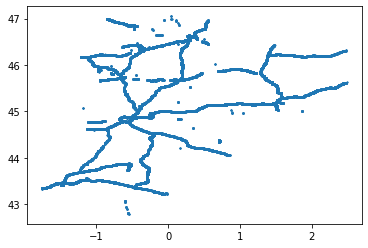

In [9]:
def display_noSimpleGraph():
        xpoints = []
        ypoints = []
        for node in noSimpleGraph.items():

                xpoints.append(nodesMap[node[0]][0])
                ypoints.append(nodesMap[node[0]][1])

        latitude = np.array(xpoints)
        longitude = np.array(ypoints)

        plt.scatter(longitude,latitude,s=1)
        plt.show()

display_noSimpleGraph()

In [10]:
def updateSimpleGraph(graph,idNode):
    if idNode not in graph:
        graph.update({idNode : {"nextNodes" :[],
                                       "prevNodes" : []}})
    return graph

In [11]:
# fonction pour trouver les prochains nœuds de la station
def nextStation(graph, startNode, nodesMap,newGraph):

    visitedNodes = set()
    stack = [(startNode, None, 0)]

    while stack:
        node, lastStationNode, lastDistance = stack.pop()

        if node not in visitedNodes:
            visitedNodes.add(node)
            if nodesMap[node][2] == 1:
                updateSimpleGraph(newGraph, node)
                if lastStationNode is not None:
                    newGraph[lastStationNode]["nextNodes"].append([node, lastDistance])
                    newGraph[node]["prevNodes"].append([lastStationNode, lastDistance])
                lastStationNode = node
                lastDistance = 0.0

            for nextNode in graph.get(node, {}).get("nextNodes", []):
                if nextNode not in visitedNodes:
                    distance = haversine([nodesMap[node][0], nodesMap[node][1]], [nodesMap[nextNode][0], nodesMap[nextNode][1]])
                    distance = round(distance, 2)
                    stack.append((nextNode, lastStationNode, round(lastDistance + distance, 2)))

    return newGraph

def createSimpleGraph(graph, nodesMap):
    newGraph = {}

    for node_id, node_data in nodesMap.items():
        if node_data[2] == 1:
            nextStation(graph, node_id, nodesMap,newGraph)
    return newGraph

simpleGraph = createSimpleGraph(noSimpleGraph, nodesMap)


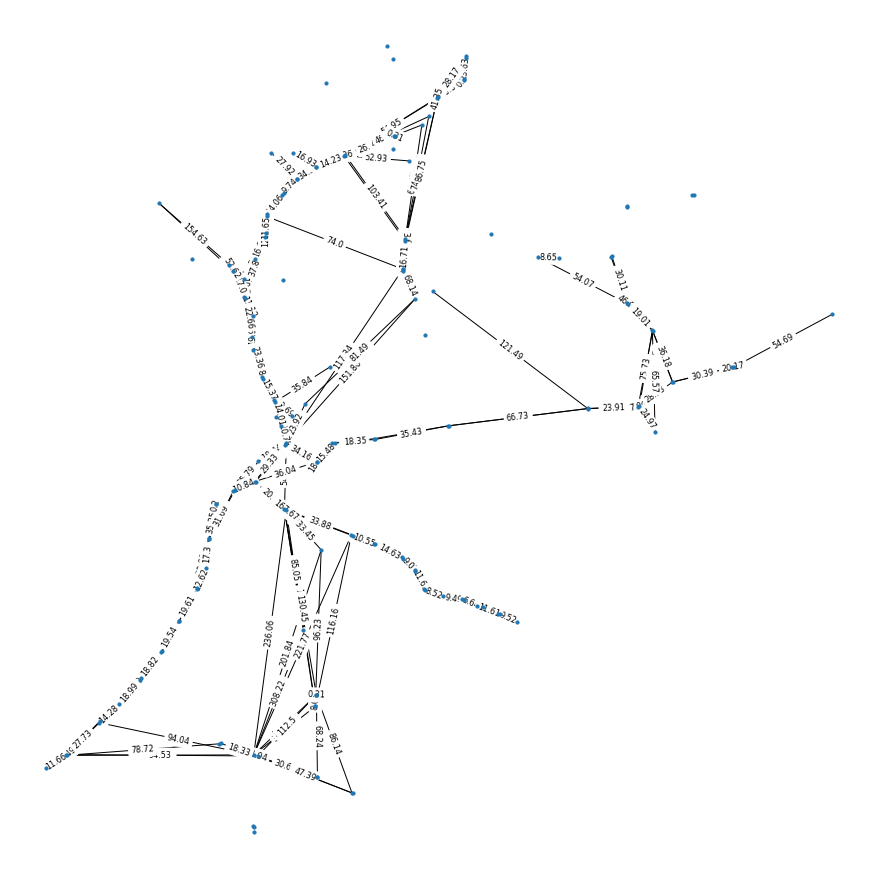

In [12]:
def display_simpleGraph(graph):
    G = nx.Graph()

    for node, data in graph.items():
        G.add_node(node, latitude=nodesMap[node][0], longitude=nodesMap[node][1])

    for node, data in graph.items():
        for next_node, distance in data.get("nextNodes", []):
            G.add_edge(node, next_node, distance=distance)

    node_positions = {node: (data['longitude'], data['latitude']) for node, data in G.nodes(data=True)}

    edge_distances = {(u, v): d['distance'] for u, v, d in G.edges(data=True)}

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos=node_positions, with_labels=False, node_size=10)
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_distances, font_size=8)
    plt.show()

# Appliquer la fonction display_simpleGraph() à newGraphs
display_simpleGraph(simpleGraph)  # Remplacez par l'ID de la station que vous souhaitez afficher

In [13]:
def floydWarshall(graph):
    matrix = {node: {} for node in graph}


    for aire in graph:
        if graph[aire]["prevNodes"]:
            neighbour1, distance1 = graph[aire]["prevNodes"][0]
            matrix[aire][neighbour1] = distance1
        if graph[aire]["nextNodes"]:
            neighbour2, distance2 = graph[aire]["nextNodes"][0]
            matrix[aire][neighbour2] = distance2

    for k in graph:
        for i in graph:
            for j in graph:
                if i != j:
                    new_distance = matrix[i].get(j, float('inf'))
                    matrix[i][j] = min(new_distance, matrix[i].get(k, float('inf')) + matrix[k].get(j, float('inf')))

    return matrix

result = floydWarshall(simpleGraph)
print(result)


{21462004: {5752418984: 13.91, 4773153946: 10.93, 889487302: 23.689999999999998, 889499418: 37.36, 889499563: 46.62, 889487349: 60.849999999999994, 85736812: 95.14999999999999, 889526539: 104.88999999999999, 1876578765: 118.94999999999999, 1876578796: 129.48, 882253871: 146.42, 621475001: 158.67, 881107084: 152.69, 255725335: 163.81, 448301527: 183.76, 1876595132: 200.64, 255725311: 208.05, 4357310089: 237.74, 726554853: 183.3, 21462872: 149.07999999999998, 1893894292: 138.3, 5761204260: 124.29, 2587088569: 108.92, 878836944: 85.56, 1835105879: 62.900000000000006, 881357268: 79.9, 387747153: 132.52, 2792877379: inf, 882439941: 25.560000000000002, 1049755706: 87.91, 9936914787: inf, 1132186836: inf, 1091814886: inf, 1049755476: inf, 606119155: inf, 606119131: inf, 4008941220: inf, 6188082759: inf, 665145798: inf, 431136244: inf, 4321937092: inf, 4321937094: inf, 883463680: inf, 4330739874: inf, 245469945: inf, 513717312: inf, 736942879: inf, 1883450379: inf, 1378466140: inf, 1832241426:

In [14]:
gPrime = {}


#Créer le graphe G' à partir du resultat de floydWarshall. Ce nouveau graphe sera utilisé par les algo EnsembleDominant
def transformGraph(dist):
    for sommet in result : 
        gPrime.update({sommet : []})
        for voisin in result[sommet]:
            if result[sommet][voisin]<= dist and result[sommet][voisin]!= float('inf') :
                gPrime[sommet].append(voisin)
    return gPrime

transformGraph(60)

{21462004: [5752418984,
  4773153946,
  889487302,
  889499418,
  889499563,
  882439941],
 4773153946: [21462004,
  889487302,
  889499418,
  889499563,
  889487349,
  882439941,
  5752418984],
 889487302: [4773153946,
  889499418,
  21462004,
  889499563,
  889487349,
  882439941,
  5752418984],
 889499418: [889487302,
  889499563,
  21462004,
  4773153946,
  889487349,
  85736812,
  5752418984],
 889499563: [889499418,
  889487349,
  21462004,
  4773153946,
  889487302,
  85736812,
  889526539],
 889487349: [889499563,
  85736812,
  4773153946,
  889487302,
  889499418,
  889526539,
  1876578765],
 85736812: [889487349,
  889526539,
  889499418,
  889499563,
  1876578765,
  1876578796,
  882253871],
 889526539: [85736812,
  1876578765,
  889499563,
  889487349,
  1876578796,
  882253871,
  621475001],
 1876578765: [889526539,
  1876578796,
  889487349,
  85736812,
  882253871,
  621475001,
  881107084],
 1876578796: [1876578765,
  882253871,
  85736812,
  889526539,
  621475001,
  8

In [15]:
def stationsOnWay(graph, way, stations):
    visited = set() # Créez un ensemble pour stocker les nœuds visités
    stack = [way[0]] # Créez une pile pour stocker les nœuds à visiter
    path = []
    print(f"Chemin initialisé au noeud {way[0]}.") # Affichez le nœud de départ

    while stack: # Tant que la pile n'est pas vide
            current_node = stack.pop()  # Nœud en haut de la pile
            visited.add(current_node)  # Marquer le nœud comme visité

            # Vérifier si le nœud courant est dans la liste des stations
            if current_node in stations:
                print(f"La station {current_node} se trouve sur le chemin.")
                path.append(current_node)

            # Si le nœud courant est le nœud de fin, recherche terminée
            if current_node == way[1]:
                print(f"Noeud {way[1]} atteint, chemin parcouru.")
                break

            # Ajouter les nœuds voisins non visités à la pile
            for next_node in graph[current_node]['nextNodes']:
                if next_node not in visited:
                    stack.append(next_node)
    return path


graph = noSimpleGraph
way = [21462872, 2587088569]
stations = [node_id for node_id, data in nodesMap.items() if data[2] == 1]
path = stationsOnWay(graph, way, stations)

print(path)

Chemin initialisé au noeud 21462872.
La station 21462872 se trouve sur le chemin.
La station 1893894292 se trouve sur le chemin.
La station 5761204260 se trouve sur le chemin.
La station 2587088569 se trouve sur le chemin.
Noeud 2587088569 atteint, chemin parcouru.
[21462872, 1893894292, 5761204260, 2587088569]


In [16]:
def verifED(graph, ed):
    for node in graph:
        if node not in ed:
            dominated = False
            for neighbour in graph[node]:
                if neighbour in ed:
                    dominated = True
                    break
            #for dominator in ed:

                #if dominator in graph[node]["nextNodes"] or dominator in graph[node]["prevNodes"]:
                    #dominated = True
                #if dominated:
                    #break
            if not dominated:
                return False
    return True

def bruteforce(graph):
    ed = []
    for node in graph:
        ed.append(node)
    validEDs = []
    validEDs.append(ed.copy())
    for i in range(1, len(graph) + 1):
        newValidEDs = []
        for validED in validEDs:
            result = recursive(graph, 1, validED)
            if result[0]:
                newValidEDs = result[1]
        if len(newValidEDs) == 0:
            if i == 1:
                print("Pas de solution trouvée")
                return []
            else:
                print("Une solution de taille " + str(len(validEDs[0])) + " a été trouvée.")
                print("Des stations de recharge sont situées sur les aires :")
                for i in validEDs[0]:
                    print(i, end=" ")
                print()
                return validEDs[0]
        else:
            validEDs = newValidEDs
    print("Une solution de taille " + str(len(validEDs[0])) + " a été trouvée.")
    print("Des stations de recharge sont situées sur les aires :")
    for i in validEDs[0]:
        print(i, end=" ")
    print()
    return validEDs[0]

def recursive(graph, elementsLeft, ed):
    validEDs = []
    if elementsLeft > 0:
        for node in graph:
            if node in ed and not graph[node] == []:
                newED = ed.copy()
                newED.remove(node)
                result = recursive(graph, elementsLeft-1, newED)
                if result[0]:
                    validEDs.append(result[1])
        if len(validEDs) > 0:
            return True, validEDs
        else:
            return False, ed 
    else:
        if verifED(graph, ed):
            #print("Une solution de taille " + str(len(ed)) + " a été trouvée.")
            #print("Des stations de recharge sont situées sur les aires :")
            #for i in ed:
                #print(i, end=" ")
            #print()
            return True, ed
        else:
            return False, ed

testGraph = {
    '5': {'nextNodes': [['3'], ['7']], 'prevNodes': []},
    '3': {'nextNodes': [['2'], ['4'], ['5']], 'prevNodes': []},
    '7': {'nextNodes': [['8'], ['5']], 'prevNodes': []},
    '2': {'nextNodes': [['3']], 'prevNodes': []},
    '4': {'nextNodes': [['3']], 'prevNodes': []},
    '8': {'nextNodes': [['4'], ['7']], 'prevNodes': []}
}

#badGraph = []
#goodGraph = []
graphPrime = transformGraph(60)
badGraph = ['4', '7']
goodGraph = ['3', '7']
#print(verifED(graphPrime, ed))
minimalED = bruteforce(graphPrime)
#print(verifED(testGraph, badGraph))
#print(verifED(testGraph, goodGraph))

Une solution de taille 54 a été trouvée.
Des stations de recharge sont situées sur les aires :
889499418 1876578765 255725311 1893894292 1835105879 881357268 1049755706 1132186836 1049755476 6188082759 665145798 4321937092 4330739874 245469945 736942879 420592074 1582689484 1411631973 726636010 4675267560 21463090 315104278 414570837 8140112875 313602118 860987198 2561901740 281227426 28125598 550518935 1452259911 1143005916 1285330579 6829109389 5478275294 36133935 1876629757 2435156796 2603568322 2789192679 3039592351 3389938497 3389938510 3723910513 4679216904 5275807924 7537908892 7801770480 7801782691 7801788139 9692793123 10202597308 10977936133 11230930425 


In [17]:
def display_ED_brutforce():
    G = nx.Graph()

    for node, data in simpleGraph.items():
        G.add_node(node, latitude=nodesMap[node][0], longitude=nodesMap[node][1])




    for node, data in simpleGraph.items():
        for next_node, distance in data.get("nextNodes", []):
            G.add_edge(node, next_node, distance=distance)

    node_positions = {node: (data['longitude'], data['latitude']) for node, data in G.nodes(data=True)}

    edge_distances = nx.get_edge_attributes(G, 'distance')

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos=node_positions, with_labels=False, node_size=10)
    nx.draw(G, pos=node_positions, nodelist=minimalED, with_labels=False, node_color="tab:red", node_size=20)
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_distances, font_size=8)
    plt.show()

display_ED_brutforce()

NameError: name 'newGraph' is not defined